
## Did you restart the notebook? 

## Loading necessary libraries 
Some pics of neural networks and code base are from this notebook: https://github.com/udacity/AIND-VUI-Capstone/blob/master/vui_notebook.ipynb and this paper https://arxiv.org/abs/1512.02595


In [1]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.98
set_session(tf.Session())
from sample_models import *
%load_ext autoreload
%autoreload 2

/home/whusym/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Automatic Speech Recognition on the DASS Corpus


# Motivation

* DASS (Digital Archive of Southern Speech)

From the website -- The Digital Archive of the Southern Speech (DASS) is an audio corpus of semi-spontaneous linguistic atlas interviews (Kretzschmar et al. 2013) derived from the Linguistic Atlas of the Gulf States (Pederson et al. 1986). It contains speech from 64 natives (34 men and 30 women, born 1886–1965) of 8 Southern US states. This sample contains a mixture of ethnicities, social classes, education levels, and ages.  http://lap3.libs.uga.edu/u/jstanley/vowelcharts/

* What kind of data do we have?

Transcription, forced alignment, and acoustic analysis.

* What do we care about?

**ACCURACY!** 

In particular, World Error Rate (WER).

A funny quote here:

**"Every time I fire a linguist, the performance of the speech recognizer goes up".** -- Frederick Jelinek, *the* pioneer of speech recognition

Is that the case? I can elaborate..... as we will see soon. 


# Background
* Landscape of speech recognition
    * HMM, GMM, etc. 
    * State of the art, Deep Neural Network (some with HMM as well)
* End-to-end model
    * Baidu's DeepSpeech
    
* Training Dataset
    * LibriSpeech
    * Publicly available (http://www.openslr.org/12/)
    * Commonly used for benchmarks


# Approaches 
* Preprocessing (spectrogram, MFCC)
    * Some other people also use raw audio or the combinations with spectrogram and MFCC.
    * Encode - decode
* Training (CNN, Bi-directional Deep RNN, TDNN+LSTM etc.) acoustic model
* Acoustic model output → language model → results
    * LM -- some part of PaddlePaddle from Baidu
* Where we borrow stuff
    * Udacity, Baidu, WER model. 

## Preprocessing

* Raw Audio: 
    * Use `python_speech_features` and `soundfile` to extract features for deep learning. 

In [2]:
from data_generator import *
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()


There are 4105 total training examples.


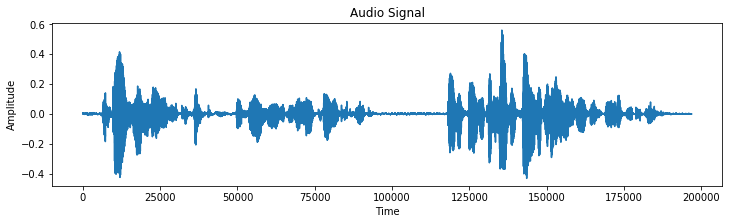

**Shape of Audio Signal** : (196907,)

**Transcript** : it galled him however to think that he and his were so poorly dressed i am afraid you can hardly find a chair miss robarts said mister crawley

In [3]:
from IPython.display import Markdown, display
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

## Feature Extraction
* Spectrogram

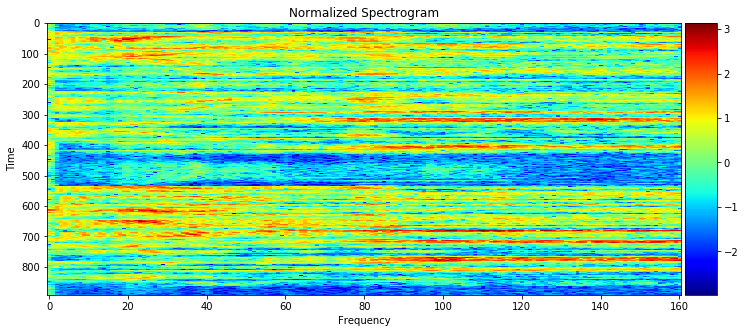

**Shape of Spectrogram** : (892, 161)

In [4]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

* MFCC

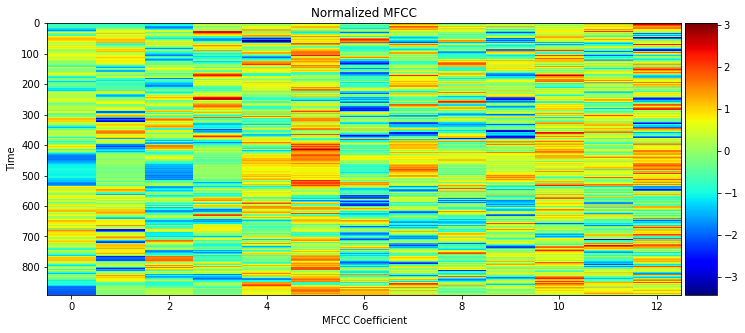

**Shape of MFCC** : (892, 13)

In [5]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

# Training

## CNN + RNN + TimeDistributed Dense

<img src="./images/cnn_rnn_model.png" width="70%">

In [6]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


/home/whusym/anaconda3/lib/python3.6/site-packages/keras/layers/recurrent.py:1028: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

### Result plot

* Loss function graph on Small dataset 
<img src="./images/cnn_small.png" width="50%">
* Large dataset — 100 hours of clean data
 <img src="./images/cnn_large.png" width="50%">

## LSTM

* Inspired by a paper
    * Kyu J. Han, Akshay Chandrashekaran, Jungsuk Kim and Ian Lane, “The CAPIO 2017 conversational speech recognition system,” arXiv 1801.00059.
    * State of the art performance in 2017

<img src="./images/tdnn-lstm.png" width="70%">

### Why LSTM?

* Created to handle the problem of “long-term dependencies” which RNN cannot solve
* Introduced by Hochreiter & Schmidhuber (1997)

More information: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### What is TDNN?
* Time Delay Neural Network recognizes phonemes and their underlying acoustic/phonetic features, independent of position in time
* Introduced by Alexander Waibel at el in 1989

In [14]:
model_4 = TDNN_LSTM(161, output_dim=29)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 150)         24300     
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 140)         21140     
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 130)         18330     
_________________________________________________________________
bn_td1 (BatchNormalization)  (None, None, 130)         520       
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 100)         92400     
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 80)          8080      
__________

### Result:
* Loss graph of small dataset
<img src="./images/lstm_small.png" width="70%">

## Bi-directional Deep RNN


<img src="images/bidirectional_rnn_model.png" width="70%">


In [8]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


### Result
* Loss graph of small dataset
<img src="./images/bi_small.png" width="70%">

## Baidu's Deep Speech 2
<img src="./images/baiduds2.jpeg" width="70%">

In [9]:
##Baidu's Deep Speech
from models import *
model_ds2 = ds2_gru_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 161)         644       
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, None, 161)         0         
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 1024)        1814528   
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 1024)        4096      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 512)         4721664   
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 512)         2048      
__________

## Experiment Details

* Run dev-clean on our laptops
* Trained on LibriSpeech clean-100-wav on Google Cloud Platform VM
    * Hardware Specs
    * Training time
* Test on DASS data. 


## Language Model

* Not very many open-source libraries available. 
* The main candidate in the market KenLM is only for scoring out of the box.
* Find one from  Baidu’s implementation on PaddlePaddle:
   * https://github.com/PaddlePaddle/DeepSpeech
* Complicated installation processes -- swig, openfst. And version problems. 
* Basic idea of incorporating a language model:
    * Beam search based on scoring from KenLM
    * For KenLM, see https://github.com/kpu/kenlm


## Live demo -- prediction

In this part, we use the our in-house trained model and the aforementioned language model to generate recognized texts from processed speech. 

First, we load necessary libraries and the builded character-based vocabulary. 

In [10]:
from language_model import *
from train_utils import get_predictions
vocab = ["'", ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Next, we load the language model

The language model we have here is from CommonCrawl, which is word-based language model (size:8.3GB) with 1.85 billion n-grams. We found the downloadable link here: https://github.com/PaddlePaddle/DeepSpeech#released-models

In [11]:
# load language model
lm = init_ext_scorer('/home/whusym/DeepSpeech/models/lm/common_crawl_00.prune01111.trie.klm', vocab)

## Make prediction in DASS 

There are a total number of 15345 of sentence-level wav files in our test set (all from DASS). We used the trained model to generate the transcptions of these files. Processing all 15345 models takes around 4.5 hours on a Google Cloud VM with 8 core CPU and 52GB RAM. In the live demo, instead of setting range() to 15345, choosing a small number (less than 5) instead (process 1 wav file roughly take 1 second. )

In [15]:
# maximal index value: 15345
all_pred = []
all_trans = []
all_audio_path = []
for i in range(15345):
    loaded_matrix, transcr, audio_path = get_predictions(index=i, 
                            partition='validation',
                            input_to_softmax=model_4, 
                            model_path='results/model_lstm_long_0421.h5',
                            spectrogram_features=True)
    res = ctc_beam_search_decoder(loaded_matrix, vocab, 50, ext_scoring_func=lm)
    all_pred.append(res[0][1])
    all_trans.append(transcr)
    all_audio_path.append(audio_path)

## Let's play an audio! 

(This is done in the live demo). 

In [34]:
Audio(all_audio_path[3])

In [35]:
all_pred[3], all_trans[3]

('he we ma do cue ha he woun dotodicrom an chans on emmo won niht',
 'She went to our church She wouldn t go to the colored church I remember one night')

In [1]:
# check the length of all predictions
# len(all_pred)

In [2]:
# print (all_pred)

## Write all the predictions and store in a txt file
That's for the WER calculations. Some recordings are too short to render transcriptions. So we put it as "EMPTY" to keep indices. 

In [29]:
file = open('my_trans_full.txt', 'w')
# file.write(all_pred)

In [30]:
for item in all_pred:
    if item != '':
        file.write("%s\n" % item)
    else:
        file.write("EMPTY\n")

## Word Error Rate(WER)

<img src="images/Worderrorrate.png" width="40%">

* S is the number of substitutions,
* D is the number of deletions,
* I is the number of insertions,
* C is the number of the corrects,
* N is the number of words in the reference (N=S+D+C)

We used package:https://github.com/belambert/asr-evaluation/tree/master/asr_evaluation

## Further work

* using pretrained models
* more training

## Backup

Here are some backup codes just in case the live demo doesn't work. These blocks show the detailed processes of generating predictions and beam search. 

And the results are as follows:

# Result

<img src="./images/3model_comparison.png" width="60%">
<img src="./images/lstm_large.png" width="60%">


In [1]:
from train_utils import *

/home/whusym/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from utils import *

In [ ]:
audio, transcr, audio_path = get_predictions(index=5, partition="valid", model_ds2, model_path, spectrogram_features=True)

In [30]:
res = ctc_beam_search_decoder(loaded, vocab, 30, ext_scoring_func=lm)


True transcription:

even in middle age they were still comely and the old grey haired women at their cottage doors had a dignity not to say majesty of their own

Predicted transcription:

even in mit la aton he wersti cimlyand the od gadyhar whamanather candors ad ad dagken eatdesi rageste ather omn


In [31]:
batch_res


[(98.94906616210938,
  'even in mit la aton he wersti cimly and the od gady hard whamanather cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.95468139648438,
  'even in mit la aton he wersti cimly and the od gady hard whamana ther cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.9559326171875,
  'even in mit la aton he wersti cimly and the old gady hard whamanather cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.9615478515625,
  'even in mit la aton he wersti cimly and the old gady hard whamana ther cade dors ad ad dagh en eatdesi rageste ather omn'),
 (99.07732391357422,
  'even in mit la aton he wersti cimly and the od gady hard whamanather cade dors ad ad dagh en eatdesi rageste other omn'),
 (99.08293914794922,
  'even in mit la aton he wersti cimly and the od gady hard whamana ther cade dors ad ad dagh en eatdesi rageste other omn'),
 (99.08419036865234,
  'even in mit la aton he wersti cimly and the old gady hard whamanather cade dors ad ad dagh en eat